In [1]:
from CGAL.CGAL_Triangulation_2 import *
from CGAL.CGAL_Kernel import Point_2
dt = Triangulation_2()
Pts = [Point_2(0,0),Point_2(1,0),Point_2(0,1),Point_2(1,1)]
for p in Pts:
    dt.insert(p)
print(dt.number_of_vertices())
print(dt)

4
5 6 2
0 0
1 0
0 1
1 1

4 0 3 
1 2 3 
2 0 4 
0 1 3 
2 1 0 
2 4 3 

3 5 2 
5 3 4 
0 5 4 
1 0 4 
3 2 1 
0 1 2 



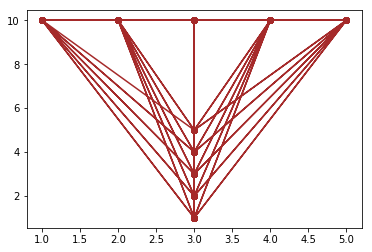

In [2]:
import matplotlib.pyplot as plt
import itertools 

fig=plt.figure()
ax=fig.add_subplot(111)
all_data = [[1,10],[2,10],[3,10],[4,10],[5,10],[3,1],[3,2],[3,3],[3,4],[3,5]]
plt.plot(
    *zip(*itertools.chain.from_iterable(itertools.combinations(all_data, 2))),
    color = 'brown', marker = 'o')

plt.show()

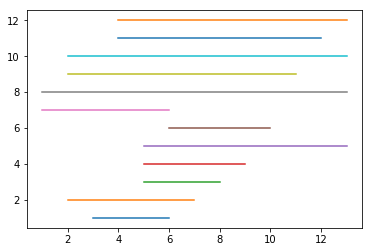

In [3]:
pairs=[(3,6),(7,2),(8,5),(9,5),(5,13),(10,6),(6,1),(1,13),(11,2),(2,13),(12,4),(4,13)]
i=0
for point in pairs:
    i+=1
    plt.plot(point,(i,i))
plt.show()

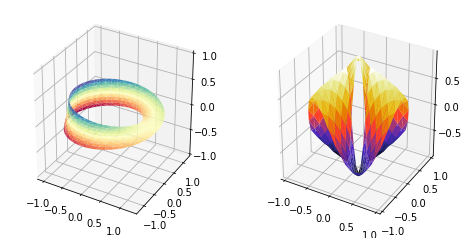

In [4]:
'''
===========================
More triangular 3D surfaces
===========================

Two additional examples of plotting surfaces with triangular mesh.

The first demonstrates use of plot_trisurf's triangles argument, and the
second sets a Triangulation object's mask and passes the object directly
to plot_trisurf.
'''

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.tri as mtri


fig = plt.figure(figsize=plt.figaspect(0.5))

#============
# First plot
#============

# Make a mesh in the space of parameterisation variables u and v
u = np.linspace(0, 2.0 * np.pi, endpoint=True, num=50)
v = np.linspace(-0.5, 0.5, endpoint=True, num=10)
u, v = np.meshgrid(u, v)
u, v = u.flatten(), v.flatten()

# This is the Mobius mapping, taking a u, v pair and returning an x, y, z
# triple
x = (1 + 0.5 * v * np.cos(u / 2.0)) * np.cos(u)
y = (1 + 0.5 * v * np.cos(u / 2.0)) * np.sin(u)
z = 0.5 * v * np.sin(u / 2.0)

# Triangulate parameter space to determine the triangles
tri = mtri.Triangulation(u, v)

# Plot the surface.  The triangles in parameter space determine which x, y, z
# points are connected by an edge.
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_trisurf(x, y, z, triangles=tri.triangles, cmap=plt.cm.Spectral)
ax.set_zlim(-1, 1)


#============
# Second plot
#============

# Make parameter spaces radii and angles.
n_angles = 36
n_radii = 8
min_radius = 0.25
radii = np.linspace(min_radius, 0.95, n_radii)

angles = np.linspace(0, 2*np.pi, n_angles, endpoint=False)
angles = np.repeat(angles[..., np.newaxis], n_radii, axis=1)
angles[:, 1::2] += np.pi/n_angles

# Map radius, angle pairs to x, y, z points.
x = (radii*np.cos(angles)).flatten()
y = (radii*np.sin(angles)).flatten()
z = (np.cos(radii)*np.cos(angles*3.0)).flatten()

# Create the Triangulation; no triangles so Delaunay triangulation created.
triang = mtri.Triangulation(x, y)

# Mask off unwanted triangles.
xmid = x[triang.triangles].mean(axis=1)
ymid = y[triang.triangles].mean(axis=1)
mask = np.where(xmid**2 + ymid**2 < min_radius**2, 1, 0)
triang.set_mask(mask)

# Plot the surface.
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot_trisurf(triang, z, cmap=plt.cm.CMRmap)


plt.show()

/Users/wagnerluizoliveiradossantos/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:97: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/Users/wagnerluizoliveiradossantos/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/wagnerluizoliveiradossantos/anaconda3/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


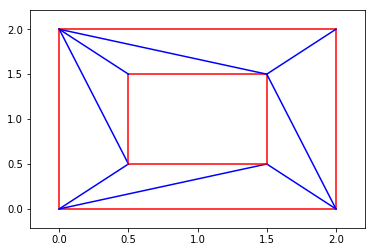

In [5]:
# This code is a python re-implementation of an example entitled
# "Triangulating a Polygonal Domain" from the CGAL documentation,
# in the Chapter entitled "2D Triangulation"
from __future__ import print_function
from CGAL.CGAL_Kernel import Point_2
from CGAL.CGAL_Triangulation_2 import Constrained_Delaunay_triangulation_2

class FaceInfo2(object):
    def __init__(self):
        self.nesting_level = -1

    def in_domain(self):
        return (self.nesting_level % 2) != 1

def mark_domains(ct, start_face, index, edge_border, face_info):
    if face_info[start_face].nesting_level != -1:
        return
    queue = [ start_face ]
    while queue != []:
        fh = queue[0]     # queue.front
        queue = queue[1:] # queue.pop_front
        if face_info[fh].nesting_level == -1:
            face_info[fh].nesting_level = index
            for i in range(3):
                e = (fh, i)
                n = fh.neighbor(i)
                if face_info[n].nesting_level == -1:
                    if ct.is_constrained(e):
                        edge_border.append(e)
                    else:
                        queue.append(n)

def mark_domain(cdt):
    """Find a mapping that can be tested to see if a face is in a domain
    Explore the set of facets connected with non constrained edges,
    and attribute to each such set a nesting level.
    We start from the facets incident to the infinite vertex, with a
    nesting level of 0. Then we recursively consider the non-explored
    facets incident to constrained edges bounding the former set and
    increase the nesting level by 1.
    Facets in the domain are those with an odd nesting level.
    """
    face_info = {}
    for face in cdt.all_faces():
        face_info[face] = FaceInfo2()
    index = 0
    border = []
    mark_domains(cdt, cdt.infinite_face(), index+1, border, face_info)
    while border != []:
        e = border[0]       # border.front
        border = border[1:] # border.pop_front
        n = e[0].neighbor(e[1])
        if face_info[n].nesting_level == -1:
            lvl = face_info[e[0]].nesting_level+1
            mark_domains(cdt, n, lvl, border, face_info)
    return face_info

def insert_polygon(cdt, polygon):
    if not polygon:
        return

    handles = [ cdt.insert(polypt) for polypt in polygon ]
    for i in range(len(polygon)-1):
        cdt.insert_constraint(handles[i], handles[i+1])
    cdt.insert_constraint(handles[-1], handles[0])

if __name__ == "__main__":

    def plot_triangulated_polygon(cdt, face_info):
        # This code is an additional element which recreates the figure
        # presented in the original CGAL example. Given the ease of which
        # a standard plotting library can be installed for python, it
        # makes sense to offer some form of visualisation directly
        try:
            import matplotlib.pyplot as plt
        except:
            print('plotting of triangulation not supported')
            return

        def rescale_plot(ax, scale = 1.1):
            xmin, xmax = ax.get_xlim()
            ymin, ymax = ax.get_ylim()
            xmid = (xmin+xmax)/2.0
            ymid = (ymin+ymax)/2.0
            xran = xmax - xmid
            yran = ymax - ymid
            ax.set_xlim( xmid - xran*scale, xmid + xran*scale )
            ax.set_ylim( ymid - yran*scale, ymid + yran*scale )

        def plot_edge(edge, *args):
            edge_seg = cdt.segment(edge)
            pts = [ edge_seg.source(), edge_seg.target() ]
            xs = [ pts[0].x(), pts[1].x() ]
            ys = [ pts[0].y(), pts[1].y() ]
            plt.plot( xs, ys, *args )

        plt.hold(True)
        for edge in cdt.finite_edges():
            if cdt.is_constrained(edge):
                plot_edge(edge, 'r-')
            else:
                if face_info[edge[0]].in_domain():
                    plot_edge(edge, 'b-')
        rescale_plot(plt.gca())
        plt.show()


    def main():
        # Construct two non-intersecting nested polygons
        polygon1 = [
            Point_2(0, 0),
            Point_2(2, 0),
            Point_2(2, 2),
            Point_2(0, 2)
        ]

        polygon2 = [
            Point_2(0.5, 0.5),
            Point_2(1.5, 0.5),
            Point_2(1.5, 1.5),
            Point_2(0.5, 1.5)
        ]

        # Insert the polygons into a constrained triangulation
        cdt = Constrained_Delaunay_triangulation_2()
        insert_polygon(cdt, polygon1)
        insert_polygon(cdt, polygon2)

        # Mark facest that are inside the domain bounded by the polygon
        face_info = mark_domain(cdt)

        plot_triangulated_polygon(cdt, face_info)

    main()

In [8]:
'''
Gerando fibras de seguranças aleatorias
'''
from random import *
random.seed() #inicia a semente dos número pseudo randômicos
random.randrange(0, 9, 2) # pares entre 0 e 9
random.choice('abcdefghij') # seleciona um dos elementos aleatoriamente
items = [1, 2, 3, 4, 5, 6, 7]
random.shuffle(items) # embaralha os itens aleatoriamente

AttributeError: 'builtin_function_or_method' object has no attribute 'seed'